Copyright 2021 DeepMind Technologies Limited

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

For training it is strongly encouraged that a GPU is used (eg a local kernel or colab pro). Training on the free colab instance can be done, but the risk of the inactivity timeout or preemption make it less reliable since training for 20 epochs takes around an hour. Ideally 50 epochs would be used to complete training.

Pretrained weights are provided so by default the colab will use these and run from start to finish in a reasonable time and replicate the results from the paper from these saved weights.

In [1]:
#@title Install modules
from IPython.display import clear_output

!pip install dm-haiku
!pip install jax
!pip install optax
clear_output()

In [2]:
#@title Imports

import collections
import dataclasses
import datetime
import enum
import functools
import itertools
import json
import os
import pickle
import random
import tempfile
from typing import Sequence

import haiku as hk
import jax
import jax.numpy as jnp
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import optax
import psutil
import scipy.sparse as sp
import seaborn as sns

In [3]:
#@title Download data

DATA_DIR = tempfile.mkdtemp()
!mkdir -p {DATA_DIR}

print(f"Copying data to {DATA_DIR} - NB this requires ~1.5G of space.")
!gsutil -m cp "gs://maths_conjectures/representation_theory/*" "{DATA_DIR}/"

# Extract the graph data.
GRAPH_DIR = os.path.join(DATA_DIR, "graph_data")
!mkdir -p {GRAPH_DIR}
!tar -xzf {DATA_DIR}/graph_data.tar.gz -C {GRAPH_DIR}

!echo "Files present:"
!ls -lh {DATA_DIR}
!du -hs {DATA_DIR}

with open(os.path.join(DATA_DIR, "graph_index_to_node_index_to_permutation.json"), "rt") as f:
    graph_index_to_node_index_to_permutation = json.load(f)
NUM_GRAPHS = len([f for f in os.listdir(GRAPH_DIR) if f.startswith("graph_")])

Copying data to /tmp/tmpbdscxv6p - NB this requires ~1.5G of space.
Copying gs://maths_conjectures/representation_theory/S9_1.tar.gz...
Copying gs://maths_conjectures/representation_theory/S9_2.tar.gz...
Copying gs://maths_conjectures/representation_theory/S9_5.tar.gz...
Copying gs://maths_conjectures/representation_theory/S9_3.tar.gz...
Copying gs://maths_conjectures/representation_theory/bruhat_data_S9.pickle...
Copying gs://maths_conjectures/representation_theory/S9_4.tar.gz...
Copying gs://maths_conjectures/representation_theory/graph_data.tar.gz...
Copying gs://maths_conjectures/representation_theory/graph_index_to_node_index_to_permutation.json...
Copying gs://maths_conjectures/representation_theory/trained_params.npz...
Files present:
total 1.5G
-rw-r--r-- 1 root root 958M Dec 11 15:52 bruhat_data_S9.pickle
drwxr-xr-x 2 root root 152K Dec 11 15:52 graph_data
-rw-r--r-- 1 root root  49M Dec 11 15:52 graph_data.tar.gz
-rw-r--r-- 1 root root 156M Dec 11 15:52 graph_index_to_node_in

In [4]:
#@title Data loading functions

#@markdown These functions load in previously generated Bruhat intervals (NetworkX graphs) and
#@markdown their associated KL polynomials (a list of integer coefficients), converting them
#@markdown into an adjacency matrix format and single label that is appropriate for our JAX model.
#@markdown The label is the degree-label'th coeefficient from the KL polynomial. See
#@markdown generate_graph_data() for details.

train_fraction = .8


def pad(iterable, size, padding=None):
  return itertools.islice(pad_infinite(iterable, padding), size)


def pad_infinite(iterable, padding=None):
  return itertools.chain(iterable, itertools.repeat(padding))


def convert_networkx_to_adjacency_input(graph):
  adjacency_matrix = nx.to_scipy_sparse_matrix(graph, format='coo')
  adjacency_matrix += sp.eye(adjacency_matrix.shape[0])
  return adjacency_matrix


@dataclasses.dataclass(frozen=True)
class GraphData:
  features: Sequence[np.ndarray]
  labels: Sequence[np.ndarray]
  adjacencies: Sequence[sp.csr_matrix]


def generate_graph_data(degree_label):
  """Generate dataset for training GraphNet model on KL data.

  This generates a dataset for training a GraphNet model.

  Args:
    degree_label: The polynomial coefficient to use as the label.

  Returns:
    An GraphData instance with features, adjacencies and labels.
  """
  kls = read_kl_coefficients()
  max_degree = max(len(kl) for kl in kls)

  ys = np.array([list(pad(kl, max_degree, 0)) for kl in kls])
  ys = ys[:, degree_label:degree_label+1]

  features = []

  for graph in iter_graph():
    feat_dict = {
        'in_centrality': nx.in_degree_centrality(graph),
        'out_centrality': nx.out_degree_centrality(graph),
    }

    curr_feature = np.zeros((len(graph), len(feat_dict)))

    for n, perm in enumerate(graph.nodes):
      for i, (name, value) in enumerate(feat_dict.items()):
        curr_feature[n,i] = value[perm]

    features.append(curr_feature)
  adjacencies = [convert_networkx_to_adjacency_input(g) for g in graphs]

  return GraphData(features=features, labels=ys, adjacencies=adjacencies)


@functools.lru_cache()
def load_graphs_from_pickle():
  assert hold_graphs_in_memory, "Should only load data from the pickle if 'hold_graphs_in_memory' is True"
  with open(os.path.join(DATA_DIR, 'bruhat_data_S9.pickle'), 'rb') as ifile:
    unused_interval_spec, unused_interval_lengths, graphs, unused_kls = pickle.load(ifile)
  return graphs


def iter_graph():
  if hold_graphs_in_memory:
    yield from load_graphs_from_pickle()
  else:
    for i in range(NUM_GRAPHS):
      filename = os.path.join(GRAPH_DIR, f"graph_{i:04d}.npz")
      yield nx.from_scipy_sparse_matrix(
          sp.load_npz(filename), create_using=nx.DiGraph)


@functools.lru_cache()
def read_kl_coefficients():
  with open(os.path.join(GRAPH_DIR, "kl_coefficients.json")) as f:
    return json.load(f)


def get_root_node(col):
  return np.bincount(col).argmin()


@dataclasses.dataclass(frozen=True)
class InputData:
  features: Sequence[np.ndarray]
  labels: Sequence[np.ndarray]
  rows: Sequence[sp.csr_matrix]
  columns: Sequence[sp.csr_matrix]
  root_nodes: Sequence[int]


def load_input_data(degree_label=1):
  """Loads input data for the specified prediction problem.

  This loads a dataset that can be used with a GraphNet model. The Bruhat
  intervals are taken from the dataset of intervals in S9 and the label
  is the coefficient of specified degree.

  The datasets are cached, and only regenerated when not found on disk.

  Args:
    degree_label: the polynomial coefficient to use as the label.
  Returns:
    Three InputData instances with features, rows, cols and labels. They are the
    full/train/test set respectively.
  """
  input_data_cache_dir = os.path.join(DATA_DIR, f"input_data_{degree_label}")

  # Extract from .tar if not already done.
  tar_path = f"{DATA_DIR}/S9_{degree_label}.tar.gz"
  cache_dir = os.path.join(DATA_DIR, f"input_data_{degree_label}")
  if os.path.exists(tar_path) and not os.path.exists(cache_dir):
    print(f"Extracting input files from {tar_path}")
    !mkdir {cache_dir}
    !tar -xzf {tar_path} -C {cache_dir}

  # Load from cache for either extracted-tar or a previously computed run.
  if os.path.exists(input_data_cache_dir):
    print(f"Loading np arrays from directory: '{input_data_cache_dir}'", flush=True)
    # Load adj
    adjacencies = [sp.load_npz(os.path.join(input_data_cache_dir, filename))
                   for filename in sorted(os.listdir(input_data_cache_dir))
                   if not filename.endswith("arrays.npz")]
    # Load np arrays
    with np.load(os.path.join(input_data_cache_dir, "arrays.npz")) as data:
      ys = data["labels"]
      features = [data[f"feature_{i:04d}"] for i in range(len(adjacencies))]
    print("Data loaded from cache.", flush=True)
  else:
    print(f"Generating data for degree_label {degree_label} and caching (~1m to generate)", flush=True)
    graph_data = generate_graph_data(degree_label)
    features = graph_data.features
    adjacencies = graph_data.adjacencies
    ys = graph_data.labels

    # Save to disk to save time in future:
    !mkdir {input_data_cache_dir}
    np.savez(os.path.join(input_data_cache_dir, "arrays.npz"),
             **{f"feature_{i:04d}": f for i, f in enumerate(features)}, labels=ys)
    for i, adj in enumerate(adjacencies):
      sp.save_npz(os.path.join(input_data_cache_dir, f"adj_{i:04d}.npz"), adj)
    print(f"Data cached to directory {input_data_cache_dir}; future runs should be much faster!")

  rows = [sp.coo_matrix(a).row for a in adjacencies]
  cols = [sp.coo_matrix(a).col for a in adjacencies]
  root_nodes = [get_root_node(col) for col in cols]

  num_training = int(len(ys) * train_fraction)

  features_train = features[:num_training]
  rows_train = [sp.coo_matrix(a).row for a in adjacencies[:num_training]]
  cols_train = [sp.coo_matrix(a).col for a in adjacencies[:num_training]]
  ys_train = ys[:num_training]
  root_nodes_train = root_nodes[:num_training]

  features_test = features[num_training:]
  rows_test = [sp.coo_matrix(a).row for a in adjacencies[num_training:]]
  cols_test = [sp.coo_matrix(a).col for a in adjacencies[num_training:]]
  ys_test = ys[num_training:]
  root_nodes_test = root_nodes[num_training:]
  return (
      InputData(features=features, rows=rows, columns=cols, labels=ys, root_nodes=root_nodes),
      InputData(features=features_train, rows=rows_train, columns=cols_train, labels=ys_train, root_nodes=root_nodes_train),
      InputData(features=features_test, rows=rows_test, columns=cols_test, labels=ys_test, root_nodes=root_nodes_test))


#@markdown As the graphs generally do not have the same number of nodes, and because
#@markdown JAX relies on data shapes being fixed and known upfront, we batch
#@markdown together a set of graphs into a large batch graph that contains each
#@markdown graph as a disconnected component.
def batch(features, rows, cols, ys, root_nodes):
  """Converts a list of training examples into a batched single graph."""
  batch_size = len(features)
  max_features = max(f.shape[0] for f in features)
  b_features = np.zeros((batch_size, max_features, features[0].shape[1]))
  b_rows = []
  b_cols = []
  b_ys = np.zeros((batch_size, 1))
  b_masks = np.zeros((batch_size, max_features, 1))
  for i in range(batch_size):
    b_features[i, :features[i].shape[0], :] = features[i]
    b_rows.append(rows[i] + i * max_features)
    b_cols.append(cols[i] + i * max_features)
    b_ys[i, 0] = ys[i, 0]
    root_node = root_nodes[i]
    b_masks[i, root_node, 0] = 1.0

  b_features = b_features.reshape((-1, b_features.shape[-1]))
  b_rows = np.concatenate(b_rows)
  b_cols = np.concatenate(b_cols)

  return b_features, b_rows, b_cols, b_ys, b_masks

In [5]:
#@title MPNN model definition code and helper functions


class Direction(enum.Enum):
  FORWARD = enum.auto()
  BACKWARD = enum.auto()
  BOTH = enum.auto()


class Reduction(enum.Enum):
  SUM = enum.auto()
  MAX = enum.auto()


class MPNN(hk.Module):
  """Sparse Message-Passing Neural Network (Gilmer et al., ICML 2017)."""

  def __init__(
      self,
      *,
      out_size: int,
      mid_size: int,
      activation,
      direction: Direction,
      residual: bool,
      reduction: Reduction,
      message_relu: bool,
      with_bias: bool,
  ):
    """Build MPNN layer.

    Args:
      out_size: Output width of the network.
      mid_size: Width of the hidden layer.
      activation: Activation function to use before the layer output.
      direction: Direction of message passing. See Direction Enum.
      residual: Whether to use resiudal connections.
      reduction: Reduction function to aggregate messages at nodes. See
        Reduction enum.
      message_relu: Whether to apply a relu on each message.
      with_bias: Whether to add biases in linear layers.

    Returns:
      The output of the MPNN layer.
    """
    super().__init__(name='mpnn_aggr')
    self.mid_size = out_size if mid_size is None else mid_size
    self.out_size = out_size
    self.activation = activation
    self.direction = direction
    self.reduction = reduction
    self.residual = residual
    self.message_relu = message_relu
    self.with_bias = with_bias

    @jax.jit
    def jax_coo_sum(rows, cols, msg_in, msg_out):
      msg_vect = msg_in[rows] + msg_out[cols]
      if message_relu:
        msg_vect = jax.nn.relu(msg_vect)
      return jnp.zeros_like(msg_out).at[rows].add(msg_vect)

    @jax.jit
    def jax_coo_max(rows, cols, msg_in, msg_out):
      msg_vect = msg_in[rows] + msg_out[cols]
      if message_relu:
        msg_vect = jax.nn.relu(msg_vect)
      return jnp.zeros_like(msg_in).at[rows].max(msg_vect)

    self.jax_coo_sum = jax_coo_sum
    self.jax_coo_max = jax_coo_max

  def __call__(self, features, rows, cols):
    if self.direction == Direction.FORWARD or self.direction == Direction.BOTH:
      m1_1 = hk.Linear(self.mid_size, with_bias=self.with_bias)
      m2_1 = hk.Linear(self.mid_size, with_bias=self.with_bias)
      msg_1_1 = m1_1(features)
      msg_2_1 = m2_1(features)
    if self.direction == Direction.BACKWARD or self.direction == Direction.BOTH:
      m1_2 = hk.Linear(self.mid_size, with_bias=self.with_bias)
      m2_2 = hk.Linear(self.mid_size, with_bias=self.with_bias)
      msg_1_2 = m1_2(features)
      msg_2_2 = m2_2(features)

    o2 = hk.Linear(self.out_size, with_bias=self.with_bias)

    if self.reduction == Reduction.MAX:
      reduction = self.jax_coo_max
    elif self.reduction == Reduction.SUM:
      reduction = self.jax_coo_sum
    else:
      raise ValueError('Unknown reduction %s' % self.reduction)

    if self.direction == Direction.FORWARD:
      msgs = reduction(rows, cols, msg_1_1, msg_2_1)
    elif self.direction == Direction.BACKWARD:
      msgs = reduction(cols, rows, msg_1_2, msg_2_2)
    elif self.direction == Direction.BOTH:
      msgs_1 = reduction(rows, cols, msg_1_1, msg_2_1)
      msgs_2 = reduction(cols, rows, msg_1_2, msg_2_2)
      msgs = jnp.concatenate([msgs_1, msgs_2], axis=-1)
      pass
    else:
      raise ValueError('Unknown direction %s' % self.direction)

    h_2 = o2(msgs)
    if self.residual:
      o1 = hk.Linear(self.out_size, with_bias=self.with_bias)
      h_1 = o1(features)
      network_output = h_1 + h_2
    else:
      network_output = h_2

    if self.activation is not None:
      network_output = self.activation(network_output)

    return network_output


class Model:

  def __init__(
      self,
      *,
      num_layers: int,
      num_features: int,
      num_classes: int,
      direction: Direction,
      reduction: Reduction,
      apply_relu_activation: bool,
      use_mask: bool,
      share: bool,
      message_relu: bool,
      with_bias: bool,
  ):
    """Get the jax model function and associated functions.

    Args:
      num_layers: The number of layers in the GraphNet - equivalently the number
        of propagation steps.
      num_features: The dimension of the hidden layers / messages.
      num_classes: The number of target classes.
      direction: Edges to pass messages along, see Direction enum.
      reduction: The reduction operation to be used to aggregate messages at
        each node at each step. See Reduction enum.
      apply_relu_activation: Whether to apply a relu at the end of each
        propogration step.
      use_mask: Boolean; should a masked prediction in central node be
        performed?
      share: Boolean; should the GNN layers be shared?
      message_relu: Boolean; should a ReLU be used in the message function?
      with_bias: Boolean; should the linear layers have bias?
    """
    self._num_layers = num_layers
    self._num_features = num_features
    self._num_classes = num_classes
    self._direction = direction
    self._reduction = reduction
    self._apply_relu_activation = apply_relu_activation
    self._use_mask = use_mask
    self._share = share
    self._message_relu = message_relu
    self._with_bias = with_bias

  def _kl_net(self, features, rows, cols, batch_size, masks):
    in_enc = hk.Linear(self._num_features)

    if self._apply_relu_activation:
      activation_fn = jax.nn.relu
    else:
      activation_fn = lambda net: net

    gnns = []
    for i in range(self._num_layers):
      if i == 0 or not self._share:
        gnns.append(
            MPNN(
                out_size=self._num_features,
                mid_size=None,
                direction=self._direction,
                reduction=self._reduction,
                activation=activation_fn,
                message_relu=self._message_relu,
                with_bias=self._with_bias,
                residual=True))
      else:
        gnns.append(gnns[-1])

    out_enc = hk.Linear(self._num_classes, with_bias=self._with_bias)

    hiddens = []
    hidden = in_enc(features)
    hiddens.append(jnp.reshape(hidden, (batch_size, -1, self._num_features)))
    for gnn in gnns:
      hidden = gnn(hidden, rows, cols)
      hiddens.append(jnp.reshape(hidden, (batch_size, -1, self._num_features)))

    hidden = jnp.reshape(hidden, (batch_size, -1, self._num_features))

    if self._use_mask:
      h_bar = jnp.sum(hidden * masks, axis=1)
    else:
      h_bar = jnp.max(hidden, axis=1)

    lgts = out_enc(h_bar)

    return hiddens, lgts

  @property
  def net(self):
    return hk.transform(self._kl_net)

  @functools.partial(jax.jit, static_argnums=(0,))
  def loss(self, params, features, rows, cols, ys, masks):
    _, lgts = self.net.apply(params, None, features, rows, cols, ys.shape[0],
                             masks)
    return -jnp.mean(
        jax.nn.log_softmax(lgts) *
        jnp.squeeze(jax.nn.one_hot(ys, self._num_classes), 1))

  @functools.partial(jax.jit, static_argnums=(0,))
  def accuracy(self, params, features, rows, cols, ys, masks):
    _, lgts = self.net.apply(params, None, features, rows, cols, ys.shape[0],
                             masks)
    pred = jnp.argmax(lgts, axis=-1)
    true_vals = jnp.squeeze(ys, axis=1)
    acc = jnp.mean(pred == true_vals)
    return acc

In [6]:
#@title Load data

#@markdown Training this model is pretty slow - an hour or so on the free tier colab, but subject to inactivity timeouts and pre-emptions.

#@markdown In order to make it possible to recreate the results from the paper reliably and quickly, we provide several helpers to either speed things up, or reduce the memory footprint:
#@markdown * Pretrained weights - greatly speeds things up by loading the trained model parameters rather than learning from the data
#@markdown * If you are running on a high memory machine (ie *not* on the free colab instance!) the input graph data can be loaded from a pickle (which is faster to load) and kept in memory (faster to re-use, but uses ~12Gb of memory). This makes no difference to training speed (it's only relevant for `generate_graph_data()` and `get_saliency_vectors()`).

use_pretrained_weights = True  #@param{type:"boolean"}
hold_graphs_in_memory = False  #@param{type:"boolean"}

gb = 1024**3
total_memory = psutil.virtual_memory().total / gb
# Less than 20Gb of RAM means we need to do some things slower, but with lower memory impact - in
# particular, we want to allow things to run on the free colab tier.
if total_memory < 20 and hold_graphs_in_memory:
    raise RuntimeError(f"It is unlikely your machine (with {total_memory}Gb) will have enough memory to complete the colab's execution!")

print("Loading input data...")
full_dataset, train_dataset, test_dataset = load_input_data(degree_label=4)

Loading input data...
Extracting input files from /tmp/tmpbdscxv6p/S9_4.tar.gz
Loading np arrays from directory: '/tmp/tmpbdscxv6p/input_data_4'
Data loaded from cache.


The below section defines the model used for predicting a given KL coefficient from an adjacency representation of the Bruhat interval. The model is a version of the Message-Passing Neural Network of Gilmer et al. While there may be other models that can also effectively model this problem, this was chosen in part due to knowledge of the structure of the KL polynomials. We treat the problem of predicting a coefficient as a classification problem, with the number of classes as the largest coefficient observed in the dataset. While this ignores ordering information in the label, we are still able to achieve high accuracies and derive insights from the network.

In [7]:
#@title Network Setup

step_size = 0.001
batch_size = 100

num_classes = np.max(train_dataset.labels) + 1
model = Model(
    num_layers=3,
    num_features=64,
    num_classes=num_classes,
    direction=Direction.BOTH,
    reduction=Reduction.SUM,
    apply_relu_activation=True,
    use_mask=False,
    share=False,
    message_relu=True,
    with_bias=True)

loss_val_gr = jax.value_and_grad(model.loss)
opt_init, opt_update = optax.adam(step_size)


def train(params, opt_state, features, rows, cols, ys, masks):
  curr_loss, gradient = loss_val_gr(params, features, rows, cols, ys, masks)
  updates, opt_state = opt_update(gradient, opt_state)
  new_params = optax.apply_updates(params, updates)
  return new_params, opt_state, curr_loss


def compute_accuracies(params_to_evaluate, dataset, batch_size=100):
  total_correct = 0.0
  for i in range(0, len(dataset.features), batch_size):
    b_features, b_rows, b_cols, b_ys, b_masks = batch(
        dataset.features[i:i + batch_size], dataset.rows[i:i + batch_size],
        dataset.columns[i:i + batch_size], dataset.labels[i:i + batch_size],
        dataset.root_nodes[i:i + batch_size])

    accs = model.accuracy(params_to_evaluate, b_features, b_rows, b_cols, b_ys,
                          b_masks)
    total_correct += accs * len(dataset.features[i:i + batch_size])
  return total_correct / len(dataset.features)


def print_accuracies(params_to_evaluate,
                     dataset_test,
                     dataset_train,
                     batch_size=100):
  train_accuracy = compute_accuracies(
      params_to_evaluate, dataset=train_dataset, batch_size=batch_size)
  test_accuracy = compute_accuracies(
      params_to_evaluate, dataset=test_dataset, batch_size=batch_size)

  combined_accuracy = np.average(
      [train_accuracy, test_accuracy],
      weights=[len(dataset_train.features),
               len(dataset_test.features)])
  print(f'Train accuracy: {train_accuracy:.3f} | '
        f'Test accuracy: {test_accuracy:.3f} | '
        f'Combined accuracy: {combined_accuracy:.3f}')

To replicate the Figure 3a from the paper, it is sufficient to use pre-trained set of parameters which were trained for 100 epochs on the 4th degree coefficient of S9. To do so, leave the above `use_pretrained_weights` set to `True` and the (**much** slower) training loop can be skipped.

To replicate the results from scratch, set `use_pretrained_weights=False` and perform training from a fresh set of parameters. The final results should be visible after a large number of epochs, and although full convergence is usually achieved before 100 epochs it is still expected to take an hour on GPU and even longer on CPU.

In [8]:
#@title Perform training / Load pretrained weights

if use_pretrained_weights:
  print("Loading pre-trained weights")
  flat_trained_params = jax.numpy.load(
      os.path.join(DATA_DIR, "trained_params.npz"))
  trained_params = collections.defaultdict(dict)
  for key, array in flat_trained_params.items():
    layer, weight_or_bias = key.split()
    assert weight_or_bias in ("w", "b"), weight_or_bias
    assert "linear" in layer, layer
    trained_params[layer][weight_or_bias] = array
  trained_params = dict(trained_params)
else:
  num_epochs = 20
  trained_params = model.net.init(
      jax.random.PRNGKey(42),
      features=train_dataset.features[0],
      rows=train_dataset.rows[0],
      cols=train_dataset.columns[0],
      batch_size=1,
      masks=train_dataset.features[0][np.newaxis, :, :])
  trained_opt_state = opt_init(trained_params)

  for ep in range(1, num_epochs + 1):
    tr_data = list(
        zip(
            train_dataset.features,
            train_dataset.rows,
            train_dataset.columns,
            train_dataset.labels,
            train_dataset.root_nodes,
        ))
    random.shuffle(tr_data)
    features_train, rows_train, cols_train, ys_train, root_nodes_train = zip(
        *tr_data)

    features_train = list(features_train)
    rows_train = list(rows_train)
    cols_train = list(cols_train)
    ys_train = np.array(ys_train)
    root_nodes_train = list(root_nodes_train)

    for i in range(0, len(features_train), batch_size):
      b_features, b_rows, b_cols, b_ys, b_masks = batch(
          features_train[i:i + batch_size],
          rows_train[i:i + batch_size],
          cols_train[i:i + batch_size],
          ys_train[i:i + batch_size],
          root_nodes_train[i:i + batch_size],
      )

      trained_params, trained_opt_state, curr_loss = train(
          trained_params,
          trained_opt_state,
          b_features,
          b_rows,
          b_cols,
          b_ys,
          b_masks,
      )

      accs = model.accuracy(
          trained_params,
          b_features,
          b_rows,
          b_cols,
          b_ys,
          b_masks,
      )
      print(datetime.datetime.now(),
            f"Iteration {i:4d} | Batch loss {curr_loss:.6f}",
            f"Batch accuracy {accs:.2f}")

    print(datetime.datetime.now(), f"Epoch {ep:2d} completed!")

    # Calculate accuracy across full dataset once per epoch
    print(datetime.datetime.now(), f"Epoch {ep:2d}       | ", end="")
    print_accuracies(trained_params, test_dataset, train_dataset)

Loading pre-trained weights


In [9]:
#@title Print model accuracies
#@markdown Baseline accuracy should be ~88%; trained accuracy should be ~98%.

#@markdown If only 20 epochs are trained for (as is the default setting above
#@markdown for training from scratch), the overall accuracy will be between
#@markdown the two, near 95%.
print('Baseline accuracy', 1 - np.mean(train_dataset.labels))
print_accuracies(trained_params, test_dataset, train_dataset)

Baseline accuracy 0.8817760828112231
Train accuracy: 0.982 | Test accuracy: 0.978 | Combined accuracy: 0.981


In [10]:
#@title Calculate salience and aggregate by edge labels
def get_salience_vectors(salience_fn, params, full_dataset):
  salient_features_arr = []
  for i in range(0, len(full_dataset.features), batch_size):
    b_features, b_rows, b_cols, b_ys, b_masks = batch(
        full_dataset.features[i:i + batch_size],
        full_dataset.rows[i:i + batch_size],
        full_dataset.columns[i:i + batch_size],
        full_dataset.labels[i:i + batch_size],
        full_dataset.root_nodes[i:i + batch_size],
    )
    salient_features = salience_fn(params, b_features, b_rows, b_cols, b_ys,
                                   b_masks)
    effective_batch_size = len(full_dataset.features[i:i + batch_size])
    salient_features_arr.extend(
        np.reshape(salient_features, [effective_batch_size, -1, 2]))
  return salient_features_arr


def aggregate_by_edges(salient_features_arr, cutoff, ys):
  refl_count = {
      'salient_all': collections.defaultdict(int),
      'all': collections.defaultdict(int)
  }
  for graph_index, (graph, saliency, label) in enumerate(
      zip(iter_graph(), salient_features_arr, ys)):
    [salient_nodes] = np.where(np.linalg.norm(saliency, axis=1) > cutoff)
    subgraph = graph.subgraph(salient_nodes)
    for reflection in get_reflections(graph_index, graph):
      refl_count['all'][reflection] += 1
    for reflection in get_reflections(graph_index, subgraph):
      refl_count['salient_all'][reflection] += 1

  norm_refl_mat = {}
  for title, counts in refl_count.items():
    reflection_mat = np.zeros((9, 9))
    # Loop over the upper triangle.
    for i in range(9):
      for j in range(i + 1, 9):
        count = counts[(i, j)] + counts[(j, i)]
        reflection_mat[i, j] = count
        reflection_mat[j, i] = count
    norm_refl_mat[title] = reflection_mat / reflection_mat.sum()

  return refl_count, norm_refl_mat


def get_reflections(graph_index, graph):
  node_index_to_permutation = graph_index_to_node_index_to_permutation[str(
      graph_index)]
  for permutation_x, permutation_y in graph.edges():
    if np.isscalar(permutation_x):
      # If the data was loaded as compressed sci-py arrays, the permutations
      # need to be looked up by index in the data loaded separate from JSON.
      permutation_x = node_index_to_permutation[str(permutation_x)]
      permutation_y = node_index_to_permutation[str(permutation_y)]
    yield tuple(i for i, (x, y) in enumerate(zip(permutation_x, permutation_y))
                if x != y)


print('Computing saliences...')
salience_fn = jax.jit(jax.grad(lambda *args: jnp.sum(model.loss(*args)), 1))
salient_features_arr = get_salience_vectors(salience_fn, trained_params,
                                            full_dataset)
saliencies = np.linalg.norm(
    np.concatenate(salient_features_arr, axis=0), axis=1)

print('Aggregating by edges...')
cutoff = np.percentile(saliencies, 99)
refl_count, norm_refl_mat = aggregate_by_edges(salient_features_arr, cutoff,
                                               full_dataset.labels)

Computing saliences...
Aggregating by edges...


The final cell replicates Figure 3a from the paper - it shows the relative frequency of different edge types in salient subgraphs compared with the frequency across the full dataset.

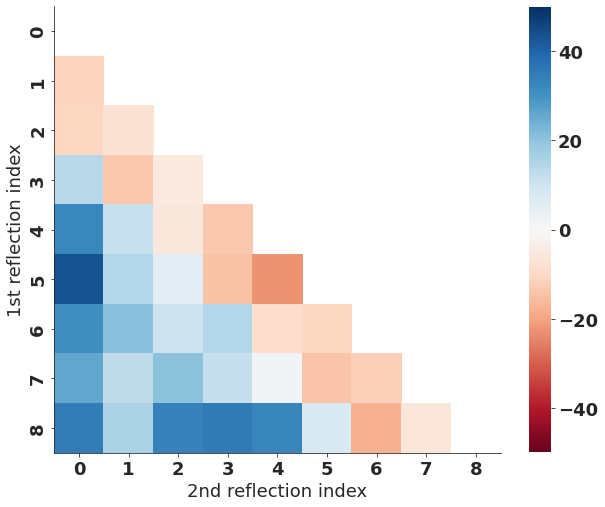

In [11]:
#@title Plot edge attribution

font = {'family': 'normal', 'weight': 'bold', 'size': 18}

matplotlib.rc('font', **font)
sns.set_style('ticks')

np.fill_diagonal(norm_refl_mat['all'], 1)  # Avoid 0/0 warning.
change_grid = ((norm_refl_mat['salient_all'] - norm_refl_mat['all']) /
               norm_refl_mat['all'] * 100)

f, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(
    change_grid,
    mask=np.triu(np.ones_like(change_grid)),
    center=0,
    square=True,
    cmap='RdBu',
    cbar_kws={'shrink': .82},
    ax=ax,
    vmin=-50,
    vmax=50)

ax.set_ylabel('1st reflection index')
ax.set_xlabel('2nd reflection index')
sns.despine()

plt.show()